In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import itertools
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz_analysis import get_full_statistics, questions, named_users
from urbanstats.games.quiz import display_question, quiz_is_guaranteed_past, compute_fractional_days

/home/kavi/anaconda3/envs/urbanstats/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
plt.rcParams["font.family"] = "monospace"

In [5]:
today_problem = int(compute_fractional_days("America/New_York"))

In [6]:
result = get_full_statistics(after_problem=49, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

In [7]:
is_valid_day = lambda x: quiz_is_guaranteed_past(x) is None and x > 50

In [8]:
mask = [is_valid_day(x) for x in num_users_by_problem.index]
xs, ys = num_users_by_problem.index[mask], num_users_by_problem[mask]

In [9]:
import sklearn.linear_model

In [10]:
result_time_relevant = result[result.last_in_batch == 1]

In [11]:
count_by_user_id = result_time_relevant.groupby("user_id").count().time
users = count_by_user_id.index[count_by_user_id > 5]

(array([7.7662e+04, 8.7100e+02, 3.1100e+02, 1.7100e+02, 1.0400e+02,
        5.7000e+01, 3.3000e+01, 3.6000e+01, 3.1000e+01, 3.6000e+01]),
 array([  1.,  33.,  65.,  97., 129., 161., 193., 225., 257., 289., 321.]),
 <BarContainer object of 10 artists>)

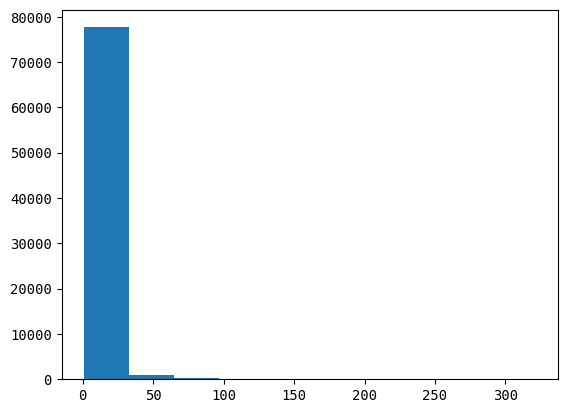

In [12]:
plt.hist(count_by_user_id)

In [13]:
times_sorted = np.array([x.timestamp() for x in sorted(result_time_relevant.time)])
time_to_index = {k : i for i, k in enumerate(times_sorted)}
def count_in_range(start, end):
    return np.searchsorted(times_sorted, end.timestamp()) - np.searchsorted(times_sorted, start.timestamp())
    return result_time_relevant[
        (start < result_time_relevant.time) & (result_time_relevant.time < end)
    ].shape[0]

In [14]:
from collections import defaultdict
time_by_user = defaultdict(list)
for u, t in zip(result_time_relevant.user_id, result_time_relevant.time):
    time_by_user[u].append(t)

In [15]:
id_to_name = {k : v for v, k in named_users.items()}

In [16]:
s = 60

In [17]:
by_user = {}
for user in tqdm.tqdm(users):
    before = after = 0
    for t in time_by_user[user]:
        before += count_in_range(t - timedelta(seconds=s), t)
        after += count_in_range(t, t + timedelta(seconds=s))
    by_user[user] = dict(after=after, before=before, delta=after - before, ratio=after/before)

  0%|          | 0/7090 [00:00<?, ?it/s]

/home/kavi/anaconda3/envs/urbanstats/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


In [18]:
by_ratio = pd.DataFrame(by_user).T.sort_values("delta")[::-1]
by_ratio.index = [id_to_name.get(x, hex(x)[2:]) for x in by_ratio.index]

In [19]:
by_ratio[:10]

,after,before,delta,ratio
vo,649.0,255.0,394.0,2.545098
c894f182d0236f5,771.0,396.0,375.0,1.946970
26fb17d5bf0c5b4,646.0,277.0,369.0,2.332130
cb49d043faaf2d,666.0,305.0,361.0,2.183607
ea570a85ed7f87f,556.0,197.0,359.0,2.822335
845098ee28f1b,586.0,229.0,357.0,2.558952
f7fc94ed86a4937,631.0,288.0,343.0,2.190972
6c60a759d1529d9,549.0,217.0,332.0,2.529954
fd060c8a15a95fe,501.0,175.0,326.0,2.862857
parth,607.0,282.0,325.0,2.152482


In [20]:
result_full = get_full_statistics(after_problem=1, debug=False)

In [21]:
def query(*days_patterns):
    result = [
        result_full[
            (result_full.problem == day)
            & (result_full.pattern.apply(lambda x: x.tolist() == pattern))
        ].user_id
        for day, pattern in days_patterns
    ]
    result = [set(x) for x in result]
    from collections import Counter
    ctr = Counter(x for xs in result for x in xs)
    ctr = sorted(ctr.items(), key=lambda x: -x[1])
    return [(id, c - len(days_patterns), c / len(days_patterns)) for id, c in ctr]

In [22]:
count_by_user_id_full = result_full.groupby("user_id").count().time

In [23]:
distro = (
    result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]
    .groupby("user_id")
    .mean()
    .score
)
counts = (
    result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]
    .groupby("user_id")
    .count()
    .score
)

In [24]:
(result_full.score == 5).groupby(result_full.problem).mean().sort_values()[::-1][:10] * 100

problem
212    83.346051
6      75.167785
167    72.229822
186    67.032967
187    63.720317
95     60.799001
10     59.459459
288    59.375000
301    58.748404
188    56.631893
Name: score, dtype: float64

In [25]:
lefts, rights = 0, 0
lefts_bad, rights_bad = 0, 0
for problem in sorted(set(result_full.problem)):
    if problem < 100:
        continue
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        q = json.load(f)
        left_correct = np.array([x["stat_a"] > x["stat_b"] for x in q])
    for_p = result_full[result_full.problem == problem]
    overall_correct = np.array(for_p[questions].sum())
    lefts += overall_correct[left_correct].sum()
    rights += overall_correct[~left_correct].sum()
    lefts_bad += (for_p.shape[0] - overall_correct)[left_correct].sum()
    rights_bad += (for_p.shape[0] - overall_correct)[~left_correct].sum()
#     count += 1
# left_correct /= count
# overall_correct /= count